In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

(4, 2) (4, 2) [0.25 0.25 0.25 0.25]


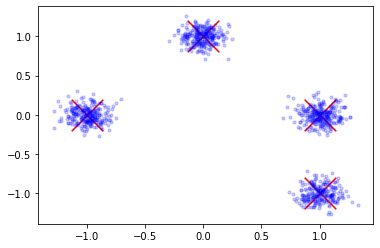

In [3]:
means = np.array([[1., 0.], [-1., 0], [0., 1.], [1, -1]])
stds = np.ones(8).reshape(4, 2)*.1
p = np.ones(4)/4.
print(means.shape, stds.shape, p)

def generate_data(n_samples):
    data = np.random.randn(n_samples, len(means), 2)
    data = data*stds+means
    
    idx = np.random.choice(np.arange(len(means)), size=n_samples, p=p)
    return data[np.arange(len(idx)), idx]
    
    
    
plt.scatter(*means.T, marker='x', color='r', s=1000)
x = generate_data(1000)
plt.scatter(*x.T, marker='o', color=(0, 0, 1., 0.2), s=10)
    


# k means clustering (teleport centroids)

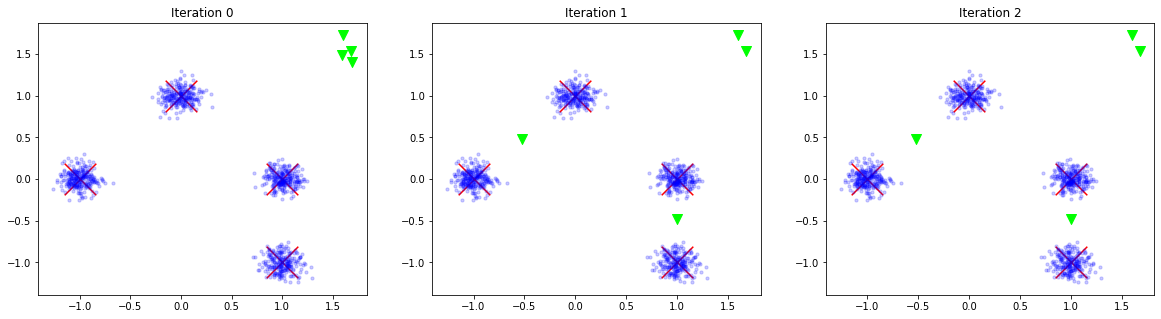

In [4]:
np.random.seed(0)
theta = np.random.randn(4, 2)/10.+1.5

x = generate_data(1000)

plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(f'Iteration {i}')
    plt.scatter(*means.T, marker='x', color='r', s=1000)
    plt.scatter(*x.T, marker='o', color=(0, 0, 1., 0.2), s=10)
    plt.scatter(*theta.T, marker='v', color=(0, 1., 0, 1.), s=100)
    
    dists = np.linalg.norm(theta[:, None, :]-x, axis=-1)
    idx = dists.argmin(axis=0)
    
    target = np.stack([x[idx==i].mean(axis=0) if (idx==i).sum()>0 else ti for i, ti in enumerate(theta)], axis=0)
    theta = target

plt.show()





# k means but with SGD

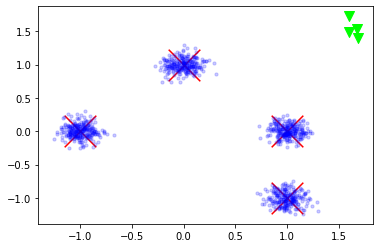

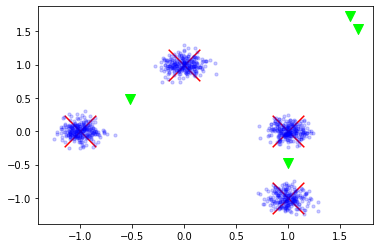

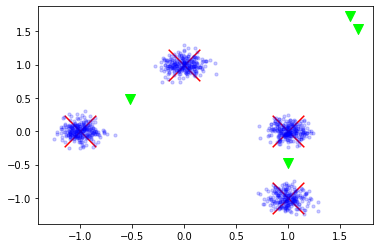

In [5]:
np.random.seed(0)

alpha = .0 # alpha=0 means the centroid teleports and becomes k means clustering
theta = np.random.randn(4, 2)/10. + 1.5

x = generate_data(1000)

for i in range(3):
    plt.scatter(*means.T, marker='x', color='r', s=1000)
    plt.scatter(*x.T, marker='o', color=(0, 0, 1., 0.2), s=10)
    plt.scatter(*theta.T, marker='v', color=(0, 1., 0, 1.), s=100)
    plt.show()
    
    dists = np.linalg.norm(theta[:, None, :]-x, axis=-1)
    idx = dists.argmin(axis=0)
    
    target = np.stack([x[idx==i].mean(axis=0) if (idx==i).sum()>0 else ti for i, ti in enumerate(theta)], axis=0)
    theta = alpha*theta + (1-alpha)*target


In [7]:
import scipy, scipy.special
scipy.special.softmax

<function scipy.special._logsumexp.softmax(x, axis=None)>

this doesn't get the double softmax idea exactly right but:

"soft k means clustering softmax"

https://www.cs.cmu.edu/~02251/recitations/recitation_soft_clustering.pdf

https://www.cs.toronto.edu/~jlucas/teaching/csc411/lectures/lec14_handout.pdf

In the second softmax step,
rather than taking another softmax (over data), they just take a weight sum (over data).
This is legal because the first softmax ensures everything is in (0,1) range.


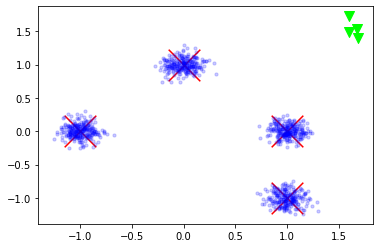

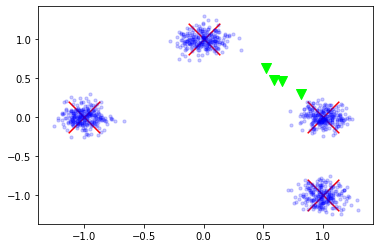

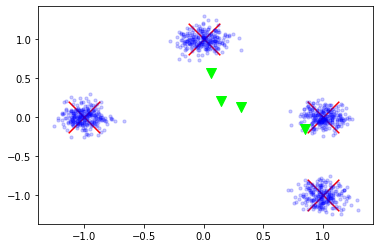

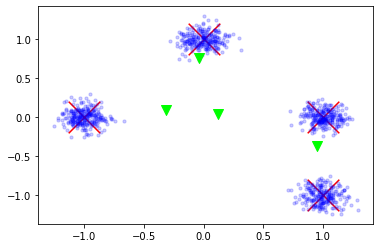

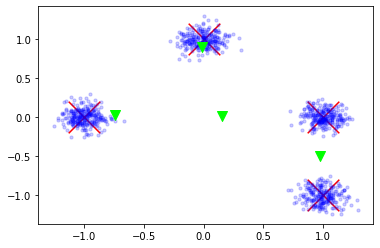

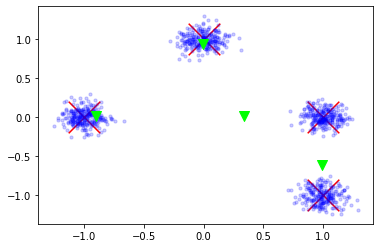

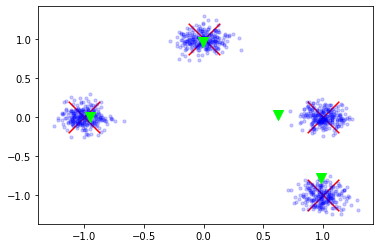

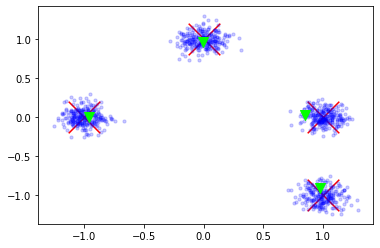

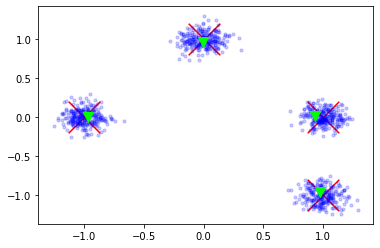

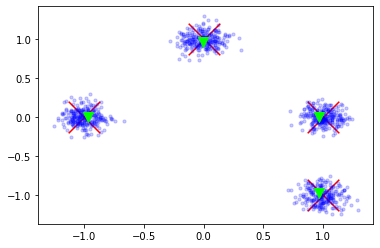

In [8]:
np.random.seed(0)

alpha = .3 # alpha=0 means the centroid teleports and becomes k means clustering
theta = np.random.randn(4, 2)/10. + 1.5

x = generate_data(1000)

for i in range(10):
    plt.scatter(*means.T, marker='x', color='r', s=1000)
    plt.scatter(*x.T, marker='o', color=(0, 0, 1., 0.2), s=10)
    plt.scatter(*theta.T, marker='v', color=(0, 1., 0, 1.), s=100)
    plt.show()
    
    beta = 5.
    dists = np.linalg.norm(theta[:, None, :]-x, axis=-1)
    # idx = dists.argmin(axis=0)
    dt = scipy.special.softmax(beta*-dists, axis=0)
    dx = scipy.special.softmax(beta*-dists, axis=1)
    # print(dx)
    # plt.plot(dx[0])
    # plt.show()
    
    # target = np.stack([x[idx==i].mean(axis=0) if (idx==i).sum()>0 else ti for i, ti in enumerate(theta)], axis=0)
    # target = np.stack([x[idx==i].mean(axis=0) if (idx==i).sum()>0 else ti for i, ti in enumerate(theta)], axis=0)
    # target = theta
    
    dtx = scipy.special.softmax(5.*dt, axis=1)
    target = dtx@x
    
    theta = alpha*theta + (1-alpha)*target

now to do with softmax attention movement and using dot product as distance with lots of clusters
and dynamically generating data for each step rather than using fixed dataset

In [220]:
import torch
from torch import nn

class HopfieldMemory(nn.Module):
    def __init__(self, n_patterns, pattern_dim, alpha=0., opt='sgd', lr=1.):
        super().__init__()
        
        # keys/stored patterns
        self.K = nn.Parameter(torch.randn(n_patterns, pattern_dim))
        # values
        self.V = nn.Parameter(torch.randn(n_patterns, pattern_dim))
        
        self.alpha = alpha
        if opt=='sgd':
            self.opt = torch.optim.SGD(self.parameters(), lr=lr, maximize=True)
        elif opt=='adam':
            self.opt = torch.optim.Adam(self.parameters(), lr=lr, maximize=True)
        
    def set_target(self, K_target, V_target=None):
        self.opt.zero_grad()
        self.K.grad = (1.-self.alpha)*(K_target-self.K)
        self.V.grad = (1.-self.alpha)*(V_target-self.V) if V_target is not None else None
    
    def step(self):
        # print(self.K[0])
        # print(self.K.grad[0])
        # prev = self.K.clone()
        self.opt.step()
        # now = self.K
        # size=(now-prev)[0].norm().detach().cpu().item()
        # print(f'took step size of {size}')
        # print()
        
    def set_target_with_data(self, xk, xv=None, beta=1., dist_metric='dot', beta2=None):
        """
        K.shape is (k, d)
        xk.shape is (n, d) is the data's queries
        xv.shape is (n, d) is the data's values
        """
        if dist_metric=='dot':
            dists = self.K@xk.transpose(-1, -2)
        elif dist_metric=='euclidean':
            dists = -(self.K[..., None, :] - xk).norm(dim=-1)
            
        # dists.shape is (..., k, n)
        
        dk = (beta*dists).softmax(dim=-2)
        # dx = (beta*dists).softmax(dim=-1)
        if beta2 is None:
            dkx = dk/dk.sum(dim=-1, keepdim=True)
        else:
            dkx = (beta2*dk).softmax(dim=-1)
        
        K_target = dkx@xk
        V_target = dkx@xv if xv is not None else None
        
        self.set_target(K_target, V_target)

        # theta = alpha*theta + (1-alpha)*target


In [221]:
torch.manual_seed(0)
hm = HopfieldMemory(5, 2)
for i in range(5):
    nK = torch.randn(5, 2)
    nV = torch.randn(5, 2)
    hm.set_target(nK, nV)
    hm.step()

In [222]:
hm.K

Parameter containing:
tensor([[ 1.3441,  2.3832],
        [-0.5665, -1.1536],
        [-2.5023,  0.8756],
        [-2.6726, -0.0313],
        [ 0.4988, -0.5233]], requires_grad=True)

In [223]:
nK

tensor([[ 1.3441,  2.3832],
        [-0.5665, -1.1536],
        [-2.5023,  0.8756],
        [-2.6726, -0.0313],
        [ 0.4988, -0.5233]])

In [159]:
from utils import *

In [219]:
aa = torch.tensor([1.])
aa.grad = torch.tensor([-.1])
print(aa.item())

a = aa.clone()
a.grad = aa.grad.clone()
opt = torch.optim.SGD([a], lr=1.)
opt.step()
print(a.item())
      
a = aa.clone()
a.grad = aa.grad.clone()
opt = torch.optim.Adam([a], lr=.1)
opt.step()
print(a.item())

1.0
1.100000023841858
1.100000023841858


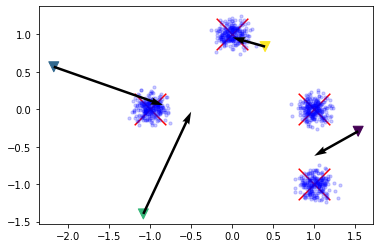

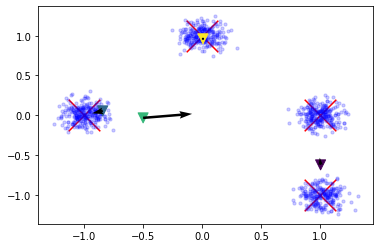

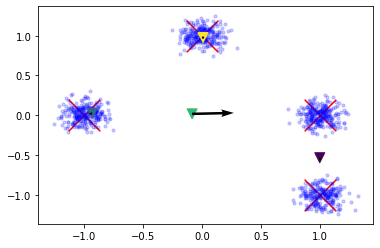

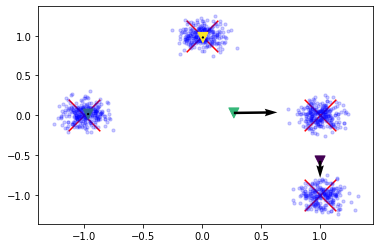

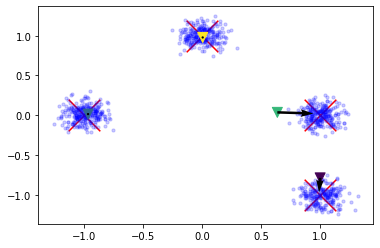

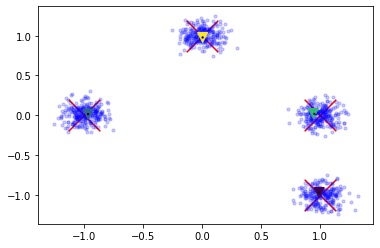

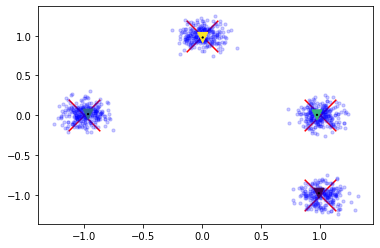

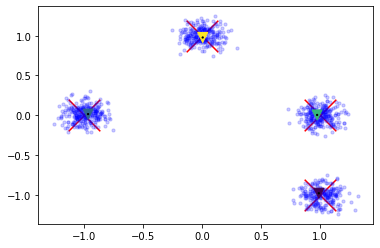

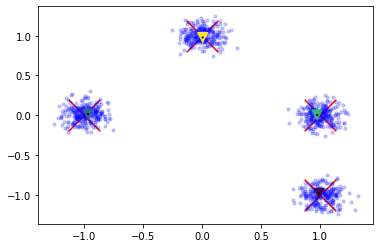

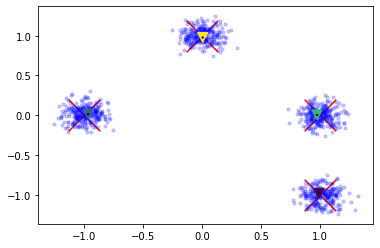

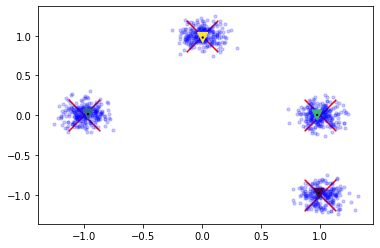

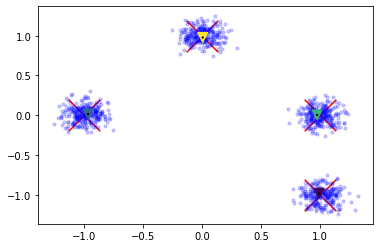

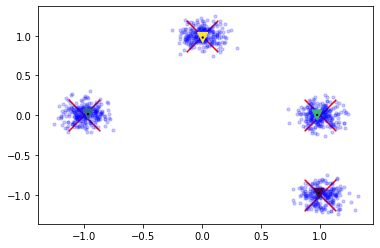

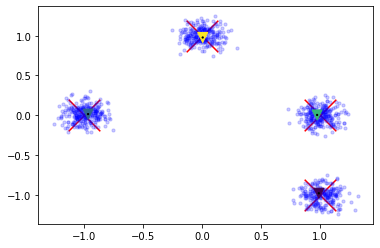

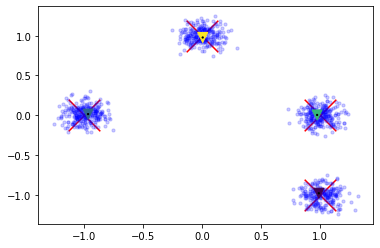

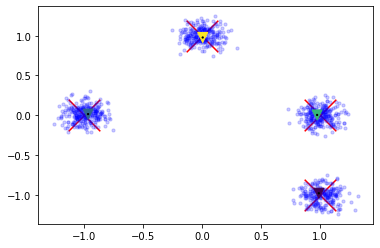

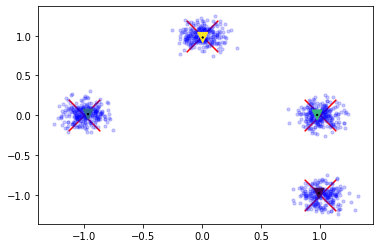

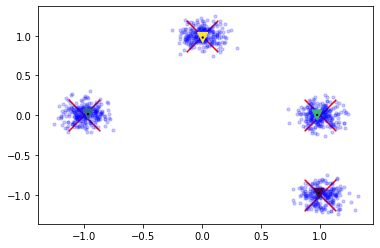

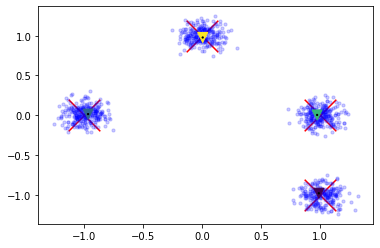

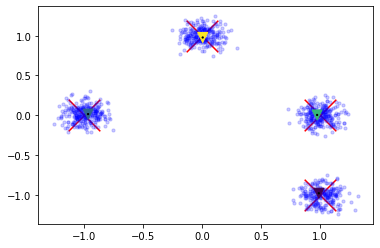

In [230]:
np.random.seed(0)
torch.manual_seed(0)

# alpha = .3 # alpha=0 means the centroid teleports and becomes k means clustering
hm = HopfieldMemory(4, 2, alpha=.0, opt='sgd', lr=1.)
# hm = HopfieldMemory(4, 2, alpha=.7, opt='adam', lr=.5)

x = generate_data(1000)

for i in range(20):
    hm.set_target_with_data(torch.from_numpy(x).to(hm.K), None, 5.0, dist_metric='euclidean', beta2=5.)
    
    plt.scatter(*means.T, marker='x', color='r', s=1000)
    plt.scatter(*x.T, marker='o', color=(0, 0, 1., 0.2), s=10)
    # plt.scatter(*to_np(hm.K).T, marker='v', color=(0, 1., 0, 1.), s=100)
    plt.scatter(*to_np(hm.K).T, marker='v', c=np.arange(4), s=100)
    plt.quiver(*to_np(hm.K).T, *to_np(hm.K.grad).T, angles='xy', scale_units='xy', scale=1)
    plt.show()
    
    hm.step()
    